In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import copy
import numpy as np
import seaborn as sns
from scipy import stats
%matplotlib inline

In [2]:
from __future__ import print_function
import os.path
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from enrich2.variant import WILD_TYPE_VARIANT
import enrich2.plots as enrich_plot
pd.set_option("display.max_rows", 20) # rows shown when pretty-printing
pd.set_option("display.max_columns", 100) # rows shown when pretty-printing


# Create dataframes, calculate ratios

In [3]:
#Using data from PANDAseq paired then counted files, no further quality filtering

#Read in data files and set BC as index
flag1 = pd.read_csv('/Users/jsimon/Documents/Lab/**RNABinderProject/SequencingRunFiles/SequencingRun_COSMIC2/PandasOutput/MCP_Competitor/barcodes_G1.count.tsv', sep='\t', 
                   dtype={"Unnamed: 0": "string"}).set_index('barcode')
flag2 = pd.read_csv('/Users/jsimon/Documents/Lab/**RNABinderProject/SequencingRunFiles/SequencingRun_COSMIC2/PandasOutput/MCP_Competitor/barcodes_G2.count.tsv', sep='\t', 
                   dtype={"Unnamed: 0": "string"}).set_index('barcode')
myc1 = pd.read_csv('/Users/jsimon/Documents/Lab/**RNABinderProject/SequencingRunFiles/SequencingRun_COSMIC2/PandasOutput/MCP_Competitor/barcodes_G3.count.tsv', sep='\t', 
                   dtype={"Unnamed: 0": "string"}).set_index('barcode')
myc2 = pd.read_csv('/Users/jsimon/Documents/Lab/**RNABinderProject/SequencingRunFiles/SequencingRun_COSMIC2/PandasOutput/MCP_Competitor/barcodes_G4.count.tsv', sep='\t', 
                   dtype={"Unnamed: 0": "string"}).set_index('barcode')

#Filter so only barcodes with myc counts of 10+ are considered (i.e. well quantified)
myc1 = myc1[myc1['count']>9]
myc2 = myc2[myc2['count']>9]

#Merge into single dataframe
data = pd.merge(flag1, flag2, on = 'barcode').rename(columns={"count_x": "flag 1 count", "count_y": "flag 2 count"})
data = pd.merge(data, myc1, on = 'barcode').rename(columns={"count": "myc 1 count"})
data = pd.merge(data, myc2, on = 'barcode').rename(columns={"count": "myc 2 count"})

#Average replicate scores
data['flag average count'] = (data['flag 1 count']+data['flag 2 count'])/2
data['myc average count'] = (data['myc 1 count']+data['myc 2 count'])/2

#Calculate ratio
data['flag/myc'] = data['flag average count']/data['myc average count']

#Add columns containg replicate ratios

data['flag1/myc1'] = data['flag 1 count']/data['myc 1 count']
data['flag2/myc2'] = data['flag 2 count']/data['myc 2 count']

#change barcodes to reverse complement

data['RevComplement'] =''

for i,row in data.iterrows():
    seq = i
    newseq = seq.replace("A", "t").replace("C", "g").replace("T", "a").replace("G", "c")
    newseq = newseq.upper() #change replaced letters to uppercase
    newseq = newseq[::-1]  #reverse strand
    data.at[i, 'RevComplement'] = newseq
    


In [4]:
#Map each barcode above to its cognate AA Variant
#-------------------------------------------------------------------------------------------------------------#
#Read in barcode:ProteinAAVariant map that you created from Pacbio data and rename columns
#What is read in from Illumina is the reverse complement of the actual barcode. 
#^To account for that, change barcodes in barcode_AAvar_map to reverse complement

barcode_AAvar_map = pd.read_csv('/Users/jsimon/Documents/Lab/**RNABinderProject/SequencingRunFiles/PacBioSequencing (**Most files moved to google drive!)/MCP_Workup/Barcode+AAvariant map MCP_v2.txt', sep='\t')
barcode_AAvar_map.rename(columns = {'condensed variant':'AA Variant', 'Unnamed: 0.1':'barcode'}, inplace=True)

#change index to be the barcode
barcode_AAvar_map = barcode_AAvar_map.set_index('barcode')

#change barcode to reverse complement

barcode_AAvar_map['RevComplement'] =''

for i,row in barcode_AAvar_map.iterrows():
    seq = i
    newseq = seq.replace("A", "t").replace("C", "g").replace("T", "a").replace("G", "c")
    newseq = newseq.upper() #change replaced letters to uppercase
    newseq = newseq[::-1]  #reverse strand
    barcode_AAvar_map.at[i, 'RevComplement'] = newseq
    
#drop unnecessary columns and change index to the rev complement barcode

barcode_AAvar_map = barcode_AAvar_map.drop(['Unnamed: 0', 'variant'], axis=1)
barcode_AAvar_map = barcode_AAvar_map.set_index('RevComplement')

#create list of positions in library in target library, including tdMCP tag

targetPositionList_str = ['282', '300', '354', '376', '463', '466', '485', '531', '532', '536', '568', '579',
                          '592', '600', '606', '608', '615', '619', '621', '626', '641', '659', '663', '717', '718',
                          '721', '723', '727', '730', '736', '738', '740', '741', '742', '743', '745', '746', '759',
                          '773', '775', '783', '792', '805', '813', '848', '855', '856', '858', '860', '861', '862',
                          '866', '867', '868', '869', '870', '871', '872', '873', '874', '875', '876', '878', '879',
                          '880', '882', '883', '888', '889', '890', '892', '910', '940', '945', '956', '969', '999',
                          '1000', '1001', '1009', '1036']


In [5]:
#Merge AAvar map ('barcode_AAvar_map') with Illumina counted barcodes and calculated ratios
data = pd.merge(barcode_AAvar_map, data, left_index=True, right_index=True)

#filter out variants not in target library
data = data[(data["AA Variant"]!="multiple AA variant") & (data["AA Variant"]!="irrelevant") & (data["AA Variant"]!="AA mutation & synon.")]

for i, row in data.iterrows():
    if str(row['AA Variant']) == "_wt":
        data.at[i, 'target'] = True
    elif str(row['AA Variant'])[3:6] == "on.":
        data.at[i, 'target'] = True
    elif str(row['AA Variant'])[3:6] in targetPositionList_str:
        data.at[i, 'target'] = True
    elif str(row['AA Variant'])[3:7] in targetPositionList_str:
        data.at[i, 'target'] = True        
    else:
        data.at[i, 'target'] = False

#filter out any variants not in our target list
data = data[data['target'] == True]

#Add columns containing only the WT residue, Position, and Mutation
for i, row in data.iterrows():
    if len(str(row['AA Variant']))==9:
        data.at[i, 'Wild Type Residue'] = str(row['AA Variant'])[:3]
        data.at[i, 'Position'] = str(int(str(row['AA Variant'])[3:6])-274)
        data.at[i, 'Mutation'] = str(row['AA Variant'])[6:]
    elif len(str(row['AA Variant']))==10:
        data.at[i, 'Wild Type Residue'] = str(row['AA Variant'])[:3]
        data.at[i, 'Position'] = str(int(str(row['AA Variant'])[3:7])-274)
        data.at[i, 'Mutation'] = str(row['AA Variant'])[7:]
    elif row['AA Variant'] == '_wt':
        data.at[i, 'Wild Type Residue'] = "wild type"
        data.at[i, 'Position'] = "wild type"
        data.at[i, 'Mutation'] = "wild type"
    elif row['AA Variant'] == 'synon.':
        data.at[i, 'Wild Type Residue'] = "synonymous"
        data.at[i, 'Position'] = "synonymous"
        data.at[i, 'Mutation'] = "synonymous"        

#Add column containing correct label

for i, row in data.iterrows():
    if row['Wild Type Residue'] == 'wild type':
        label = 'wild type'
    elif row['Wild Type Residue'] == 'synonymous':
        label = 'synon.'
    else:
        label = str(row['Wild Type Residue']) + str(row['Position']) + str(row['Mutation'])
    data.at[i, 'Label'] = label

#reset index
data.index.name = 'barcode'
data = data.reset_index()


In [6]:
#Recalculate scores, internally normalizing to mean wild type score
#------------------------------------------------------------------------------------------------#

#Calculate barcode frequency and impose cutoff
data['Barcode frequency'] = (data['flag 1 count'] + data['flag 2 count'] + data['myc 1 count'] + data['myc 2 count'])/(data['flag 1 count'].sum() + data['flag 2 count'].sum() + data['myc 1 count'].sum() + data['myc 2 count'].sum())

data = data[data['Barcode frequency'] > 0.000016]

#Calculate average wild type score
wildtype = data[(data['AA Variant'] == "_wt")]
mean_score = wildtype['flag/myc'].mean()
mean_score1 = wildtype['flag1/myc1'].mean()
mean_score2 = wildtype['flag2/myc2'].mean()

#Create new column to hold data and normalize scores, adding the data to this column
data['flag/myc, WT normalized, BC level'] = data['flag/myc']/mean_score
data['flag1/myc1, WT normalized, BC level'] = data['flag1/myc1']/mean_score1
data['flag2/myc2, WT normalized, BC level'] = data['flag2/myc2']/mean_score2

#Count number of barcodes per variant

data['Number of Barcodes/AA Var'] = data['AA Variant'].map(data['AA Variant'].value_counts())

data

,barcode,AA Variant,flag 1 count,flag 2 count,myc 1 count,myc 2 count,flag average count,myc average count,flag/myc,flag1/myc1,flag2/myc2,RevComplement,target,Wild Type Residue,Position,Mutation,Label,Barcode frequency,"flag/myc, WT normalized, BC level","flag1/myc1, WT normalized, BC level","flag2/myc2, WT normalized, BC level",Number of Barcodes/AA Var
2,TACCACCTGGTCAGAT,_wt,279,271,337,256,275.0,296.5,0.927487,0.827893,1.058594,ATCTGACCAGGTGGTA,True,wild type,wild type,wild type,wild type,0.000082,0.738274,0.704202,0.755929,51
3,CGCGCGCTAAGCAAAG,_wt,74,72,67,42,73.0,54.5,1.339450,1.104478,1.714286,CTTTGCTTAGCGCGCG,True,wild type,wild type,wild type,wild type,0.000018,1.066193,0.939463,1.224150,51
4,ATATGCACAACATCAA,_wt,128,104,90,70,116.0,80.0,1.450000,1.422222,1.485714,TTGATGTTGTGCATAT,True,wild type,wild type,wild type,wild type,0.000028,1.154190,1.209736,1.060930,51
6,GGCAGTAAATGAAAGC,_wt,68,65,61,45,66.5,53.0,1.254717,1.114754,1.444444,GCTTTCATTTACTGCC,True,wild type,wild type,wild type,wild type,0.000017,0.998746,0.948205,1.031460,51
7,AGCTTGAAGTTACAAT,_wt,73,83,69,73,78.0,71.0,1.098592,1.057971,1.136986,ATTGTAACTTCAAGCT,True,wild type,wild type,wild type,wild type,0.000021,0.874471,0.899905,0.811908,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44919,CATCAACATAATCGTA,synon.,53,80,50,47,66.5,48.5,1.371134,1.060000,1.702128,TACGATTATGTTGATG,True,synonymous,synonymous,synonymous,synon.,0.000017,1.091413,0.901631,1.215468,1103
44920,AAACGCCTCCAAATAC,synon.,138,129,197,170,133.5,183.5,0.727520,0.700508,0.758824,GTATTTGGAGGCGTTT,True,synonymous,synonymous,synonymous,synon.,0.000046,0.579101,0.595849,0.541866,1103
44925,AGAACTGATGGCAGAA,synon.,214,225,226,189,219.5,207.5,1.057831,0.946903,1.190476,TTCTGCCATCAGTTCT,True,synonymous,synonymous,synonymous,synon.,0.000062,0.842027,0.805431,0.850104,1103
44926,GAGTTAAAGAAGAAGG,synon.,110,109,50,47,109.5,48.5,2.257732,2.200000,2.319149,CCTTCTTCTTTAACTC,True,synonymous,synonymous,synonymous,synon.,0.000023,1.797139,1.871310,1.656076,1103


# Heatmap

In [7]:
#Create dataframe to use in heatmap plotting

#Change mutation to single letter abbreviations
heatmap_data = data

for i, row in heatmap_data.iterrows():
    if row['Mutation'] == 'Arg':
        heatmap_data.at[i, 'Mutation'] = 'R'
    elif row['Mutation'] == 'His':
        heatmap_data.at[i, 'Mutation'] = 'H'
    elif row['Mutation'] == 'Lys':
        heatmap_data.at[i, 'Mutation'] = 'K'
    elif row['Mutation'] == 'Asp':
        heatmap_data.at[i, 'Mutation'] = 'D'
    elif row['Mutation'] == 'Glu':
        heatmap_data.at[i, 'Mutation'] = 'E'
    elif row['Mutation'] == 'Ser':
        heatmap_data.at[i, 'Mutation'] = 'S'
    elif row['Mutation'] == 'Thr':
        heatmap_data.at[i, 'Mutation'] = 'T'
    elif row['Mutation'] == 'Asn':
        heatmap_data.at[i, 'Mutation'] = 'N'
    elif row['Mutation'] == 'Gln':
        heatmap_data.at[i, 'Mutation'] = 'Q'
    elif row['Mutation'] == 'Cys':
        heatmap_data.at[i, 'Mutation'] = 'C'
    elif row['Mutation'] == 'Gly':
        heatmap_data.at[i, 'Mutation'] = 'G'
    elif row['Mutation'] == 'Pro':
        heatmap_data.at[i, 'Mutation'] = 'P'
    elif row['Mutation'] == 'Ala':
        heatmap_data.at[i, 'Mutation'] = 'A'
    elif row['Mutation'] == 'Val':
        heatmap_data.at[i, 'Mutation'] = 'V'
    elif row['Mutation'] == 'Ile':
        heatmap_data.at[i, 'Mutation'] = 'I'
    elif row['Mutation'] == 'Leu':
        heatmap_data.at[i, 'Mutation'] = 'L'
    elif row['Mutation'] == 'Met':
        heatmap_data.at[i, 'Mutation'] = 'M'
    elif row['Mutation'] == 'Phe':
        heatmap_data.at[i, 'Mutation'] = 'F'      
    elif row['Mutation'] == 'Tyr':
        heatmap_data.at[i, 'Mutation'] = 'Y'   
    elif row['Mutation'] == 'Trp':
        heatmap_data.at[i, 'Mutation'] = 'W' 
    elif row['Mutation'] == 'Ter':
        heatmap_data.at[i, 'Mutation'] = '*'    
    
#Include only variants with 3 or more barcodes
heatmap_data = heatmap_data[heatmap_data['Number of Barcodes/AA Var'] != 0]
heatmap_data = heatmap_data[heatmap_data['Number of Barcodes/AA Var'] != 1]
heatmap_data = heatmap_data[heatmap_data['Number of Barcodes/AA Var'] != 2]

#remove wild type data
heatmap_data = heatmap_data[heatmap_data['Mutation'] != 'wild type or synon.']

#restructure it to be in the correct form for a heatmap. Each value is the average ratio for that mutation
#at that position
heatmap_data_dmso = heatmap_data.groupby(['Position', 'Mutation'])['flag/myc, WT normalized, BC level'].mean().unstack()

#transpose data so ORF position is on the x-axis
heatmap_data_dmso= heatmap_data_dmso.transpose()

# Define the desired order of columns
desired_order = [8, 26, 80, 102, 189, 192, 211, 257, 258, 262, 294, 305, 318, 326, 332, 334, 341, 345, 347, 367, 385, 389, 443, 444, 447, 449, 453, 456, 462, 464, 466, 467, 468, 469, 471, 472, 485, 499, 501, 509, 518, 531, 539, 574, 581, 582, 584, 586, 587, 588, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 604, 605, 606, 608, 609, 614, 615, 616, 618, 636, 666, 671, 682, 695, 725, 726, 727, 735, 762]
desired_order = [str(value) for value in desired_order]

# Reorder the columns based on the desired order
heatmap_data_dmso = heatmap_data_dmso[desired_order]


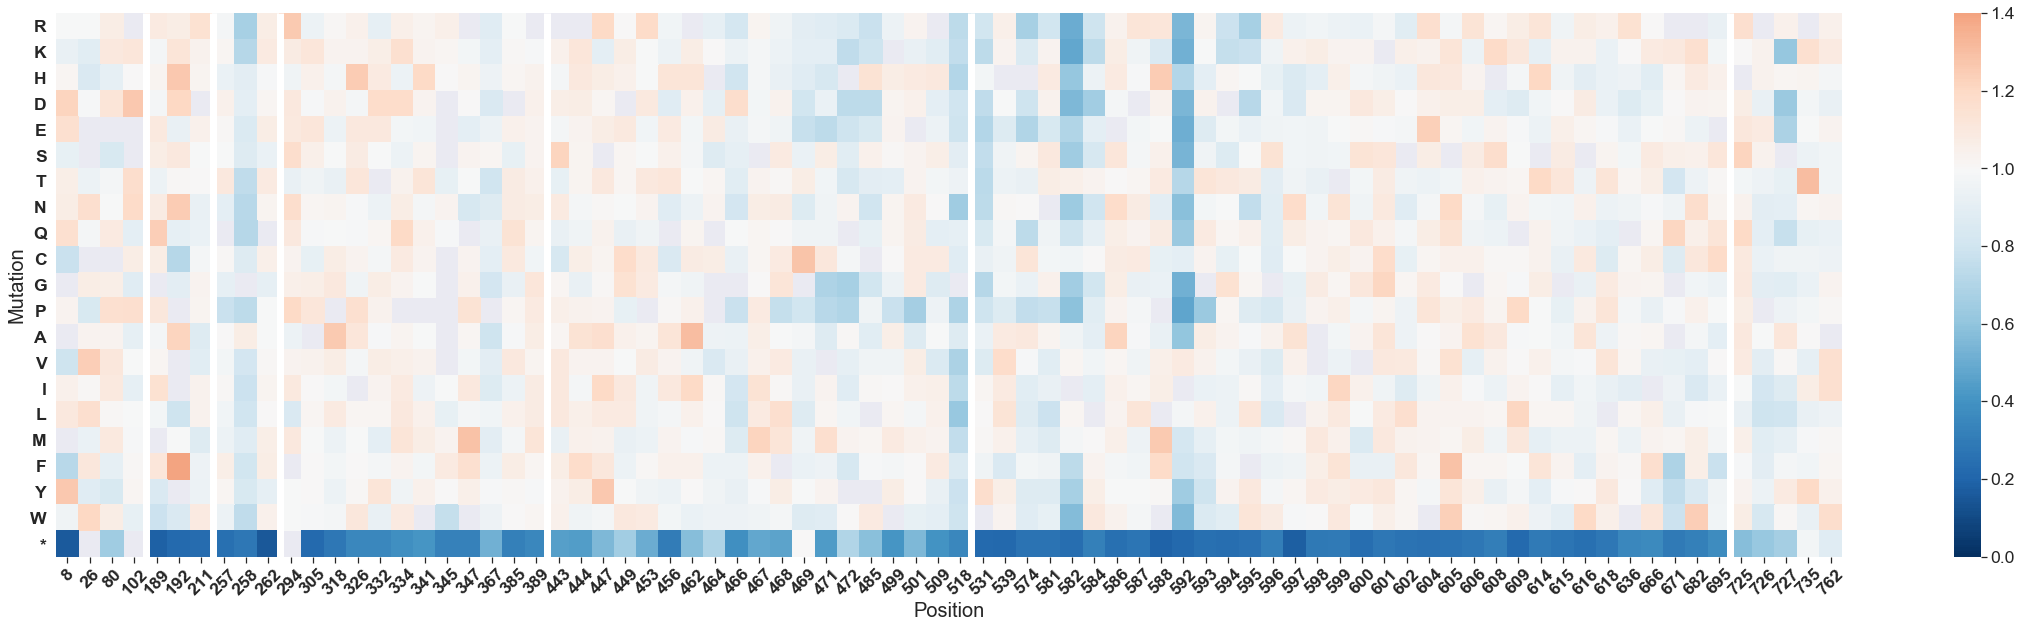

In [8]:
import matplotlib.colors as mcolors
import matplotlib as mpl

sns.set(font_scale=1.6)

orders = ['R' ,'K', 'H', 'D', 'E', 'S', 'T', 'N', 'Q', 'C', 'G', 'P', 'A', 'V', 'I', 'L', 'M', 'F', 'Y', 'W', '*']

plt.figure(figsize = (40,10))

# Reindex data
reindexed_data = heatmap_data_dmso.reindex(orders, axis=0)

# Create a mask for NaN values
mask = reindexed_data.isna()

# Create a custom colormap for NaN values and another one for the actual data
cmap_nan = mcolors.ListedColormap(['black'])
cmap_data = plt.cm.RdBu_r

# Plot NaN values with specific color
sns.heatmap(reindexed_data, mask=~mask, cmap=cmap_nan, cbar=False)

# Plot the rest of the data with the original colormap
ax = sns.heatmap(reindexed_data, mask=mask, cmap=cmap_data, vmin=0, vmax=1.4, center=1)

#plt.title('Activity+CRAF Scores', fontsize = 30)
plt.xlabel('Position', fontsize = 20, fontname='Sans Serif')
plt.ylabel('Mutation', fontsize = 20, fontname='Sans Serif')
plt.yticks(rotation=0)
plt.xticks(rotation=45)

# Make tick labels bold
for label in plt.gca().get_yticklabels():
    label.set_fontweight('bold')
    label.set_fontname('Sans Serif')
    
for label in plt.gca().get_xticklabels():
    label.set_fontweight('bold')
    label.set_fontname('Sans Serif')
    
plt.tick_params(left=False, bottom=True) ## other options are right and top
ax.vlines([4, 7, 10, 22, 41, 75], *ax.get_ylim(), linewidth=7, color = 'white')

plt.savefig('Abundance Heatmap.svg')


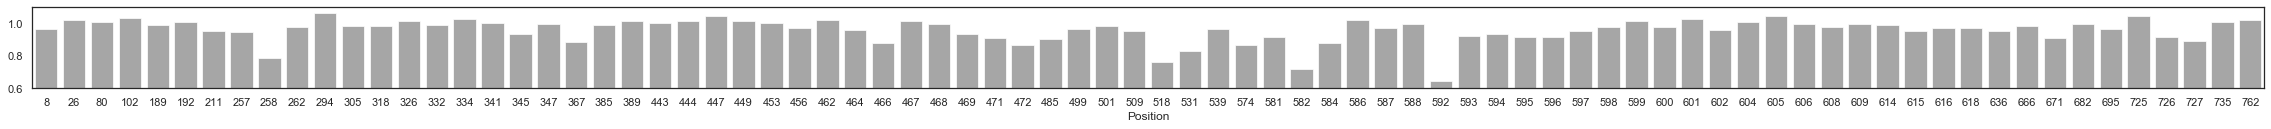

In [9]:
sns.set(font_scale=1.0)
sns.set(style='white')

# Calculate the average values at each position
bargraph_data = heatmap_data.groupby(['Position', 'Mutation'])['flag/myc, WT normalized, BC level'].mean().reset_index()
bargraph_data = bargraph_data.groupby(['Position'])['flag/myc, WT normalized, BC level'].mean()

# Define the desired order of columns
desired_order = [8, 26, 80, 102, 189, 192, 211, 257, 258, 262, 294, 305, 318, 326, 332, 334, 341, 345, 347, 367, 385, 389, 443, 444, 447, 449, 453, 456, 462, 464, 466, 467, 468, 469, 471, 472, 485, 499, 501, 509, 518, 531, 539, 574, 581, 582, 584, 586, 587, 588, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 604, 605, 606, 608, 609, 614, 615, 616, 618, 636, 666, 671, 682, 695, 725, 726, 727, 735, 762]
desired_order = [str(value) for value in desired_order]

# Reorder the columns based on the desired order
bargraph_data = bargraph_data[desired_order]

plt.figure(figsize = (40,1.5))

#Plot the barplot
sns.barplot(x=bargraph_data.index, y=bargraph_data.values, color='gray', alpha=0.7, 
            orient='v', 
            ci=None,
            order = desired_order,
            #width = 1.0,
           )


#Change ylimit
plt.ylim(0.6, 1.1)

plt.savefig('Abundance Bar Plot.svg')

# Score Plots

In [10]:
#Create dataframe to use to plot replicate Strep/Flag scores at the AA Variant Level. Also include pValues
#-----------------------------------------------------------------------------------#
    
#Include only variants with 3 or more barcodes
Replicate_score_data = data[data['Number of Barcodes/AA Var'] != 0]
Replicate_score_data = Replicate_score_data[Replicate_score_data['Number of Barcodes/AA Var'] != 1]
Replicate_score_data = Replicate_score_data[Replicate_score_data['Number of Barcodes/AA Var'] != 2]

#Group by AA Variant
Replicate_score_data = Replicate_score_data.groupby(['Label'])['flag/myc, WT normalized, BC level', 'flag1/myc1, WT normalized, BC level', 
                                                               'flag2/myc2, WT normalized, BC level'].mean()

Replicate_score_data = Replicate_score_data.rename(columns={"flag/myc, WT normalized, BC level": "flag/myc, WT normalized, protein variant", 
                                                            "flag1/myc1, WT normalized, BC level": "flag1/myc1, WT normalized, protein variant",
                                                            'flag2/myc2, WT normalized, BC level':'flag2/myc2, WT normalized, protein variant'})
Replicate_score_data


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # Remove the CWD from sys.path while we load stuff.


,"flag/myc, WT normalized, protein variant","flag1/myc1, WT normalized, protein variant","flag2/myc2, WT normalized, protein variant"
Label,,,
Ala305Arg,0.941921,0.903901,0.955060
Ala305Asn,1.020324,1.063061,0.965658
Ala305Asp,0.988741,0.981359,0.979602
Ala305Cys,0.917829,0.937421,0.884198
Ala305Gln,0.989324,1.030807,0.951559
...,...,...,...
Val600Thr,0.971432,0.917137,1.024427
Val600Trp,0.999375,1.012247,0.986331
Val600Tyr,1.088260,1.066824,1.109406


LinregressResult(slope=0.8603610885415575, intercept=0.13798766696927411, rvalue=0.8666231552485315, pvalue=0.0, stderr=0.012537691058499417)


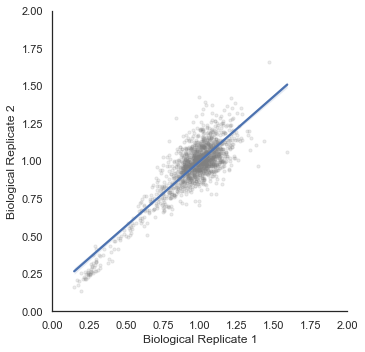

In [12]:
sns.set(style='white')

#Plot replicate scores

myplot = sns.lmplot(data=Replicate_score_data, x='flag1/myc1, WT normalized, protein variant',
                    y='flag2/myc2, WT normalized, protein variant',
                    scatter_kws={"color":"grey", "s": 10, "alpha":0.15})

#plt.title("Replicate Expression Scores (Protein Variants)", pad=20)

myplot.set(ylim=(0, 2))
myplot.set(xlim=(0, 2))
plt.xlabel('Biological Replicate 1')
plt.ylabel('Biological Replicate 2')
plt.savefig('Expression reps.svg')


print(stats.linregress(Replicate_score_data["flag1/myc1, WT normalized, protein variant"], 
                       Replicate_score_data["flag2/myc2, WT normalized, protein variant"]))



# Synonymous Distribution

In [13]:
#Create new dataframe containing only wild type synonymous variants and their barcodes
SynonDist = data[data['AA Variant'] == "synon."]
SynonDist = SynonDist.set_index('barcode')

#Read in excel file originally created using Enrich2 that maps genomic variants to barcodes
raw_barcodemap = pd.read_csv('/Users/jsimon/Documents/Lab/**RNABinderProject/SequencingRunFiles/PacBioSequencing (**Most files moved to google drive!)/MCP_Workup/Enrich2_GenerateMCPmap/tsv/t1_lib/raw_barcodemap.tsv', sep='\t', 
                   dtype={"Unnamed: 0": "string"})

raw_barcodemap = raw_barcodemap.rename(columns={'Unnamed: 0': 'BC', 'value': 'genomic variant'}).set_index('BC')

#change barcode to reverse complement
raw_barcodemap['RevComplement'] =''

for i,row in raw_barcodemap.iterrows():
    seq = i
    newseq = seq.replace("A", "t").replace("C", "g").replace("T", "a").replace("G", "c")
    newseq = newseq.upper() #change replaced letters to uppercase
    newseq = newseq[::-1]  #reverse strand
    raw_barcodemap.at[i, 'RevComplement'] = newseq
    
raw_barcodemap = raw_barcodemap.set_index('RevComplement')
raw_barcodemap

#merge data_SynonDist and raw_barcodemap dataframes
SynonDist = SynonDist.merge(raw_barcodemap, left_index = True, right_index = True)


#Count number of barcodes per variant

SynonDist['Number of Barcodes/AA Var'] = SynonDist['genomic variant'].map(SynonDist['genomic variant'].value_counts())

    
#Include only variants with 3 or more barcodes
SynonDist = SynonDist[SynonDist['Number of Barcodes/AA Var'] != 0]
SynonDist = SynonDist[SynonDist['Number of Barcodes/AA Var'] != 1]
SynonDist = SynonDist[SynonDist['Number of Barcodes/AA Var'] != 2]



#Group by AA Variant
SynonDist = SynonDist.groupby(['genomic variant'])['flag/myc, WT normalized, BC level', 
                                                   'flag1/myc1, WT normalized, BC level', 
                                                   'flag2/myc2, WT normalized, BC level', 
                                                    ].mean()

SynonDist


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,"flag/myc, WT normalized, BC level","flag1/myc1, WT normalized, BC level","flag2/myc2, WT normalized, BC level"
genomic variant,,,
"c.1126A>T (p.=), c.1127G>C (p.=)",0.986628,0.928663,1.063947
c.1398C>T (p.=),0.952842,0.962294,0.934515
c.1455C>T (p.=),1.023495,1.036196,1.022668
c.1593G>A (p.=),1.021954,0.960133,1.162403
c.1596C>A (p.=),1.177909,1.123515,1.235555
...,...,...,...
"c.3001A>T (p.=), c.3002G>C (p.=)",1.077299,1.069425,1.116550
"c.3025C>A (p.=), c.3027G>A (p.=)",1.033858,1.025920,1.061678
c.3108C>T (p.=),1.111236,1.177245,1.027724


In [14]:
SynonDist["flag/myc, WT normalized, BC level"].mean()

1.0347836646728472

In [15]:
SynonDist["flag/myc, WT normalized, BC level"].std()

0.08602553704016941

In [16]:
upper_cutoff = 1+2*SynonDist["flag/myc, WT normalized, BC level"].std()
lower_cutoff = 1-2*SynonDist["flag/myc, WT normalized, BC level"].std()
print('Cutoffs = ' + str(upper_cutoff) + ' and ' + str(lower_cutoff))

Cutoffs = 1.172051074080339 and 0.8279489259196612


In [17]:
for i, row in Replicate_score_data.iterrows():
    if row['flag/myc, WT normalized, protein variant']>upper_cutoff:
        Replicate_score_data.at[i, 'Classification'] = 'Increased Abundance'
    elif row ['flag/myc, WT normalized, protein variant']<lower_cutoff:
        Replicate_score_data.at[i, 'Classification'] = 'Decreased Abundance'
    else:
        Replicate_score_data.at[i, 'Classification'] = 'Wild Type-Like'
    

In [19]:
Replicate_score_data.to_csv('Abundance_Replicate Score Data_frequency 0.000016_3BC minimum.tsv', sep='\t')

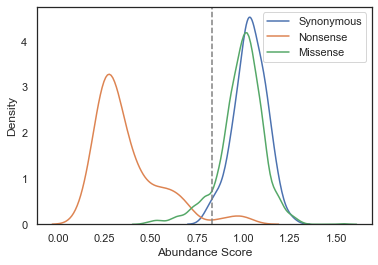

In [33]:
#Plot non-synonymous and synonymous distributions

synonVar = SynonDist['flag/myc, WT normalized, BC level']
sns.distplot(synonVar, bins = 30, axlabel='Expression Score', hist=False, label = 'Synonymous')

nonsenseScores = []
missenseScores = []

for i, row in Replicate_score_data.iterrows():
    var = str(i)
    score = row['flag/myc, WT normalized, protein variant']
    if "Ter" in var:
        nonsenseScores.append(score)
    elif "synon." in var:
        continue
    elif "_wt" in var:
        continue
    else:
        missenseScores.append(score)
        
sns.distplot(nonsenseScores, bins = 100, axlabel='Expression Score', hist=False, label = 'Nonsense')
sns.distplot(missenseScores, bins = 1000, axlabel='Expression Score', hist=False, label = 'Missense')

plt.ylabel('Density')
plt.xlabel('Abundance Score')
#plt.xlim([0, 1.75])
#plt.ylim([0,5])

plt.axvline(x=lower_cutoff, color = 'gray', linestyle = 'dashed')

plt.savefig('Abundance Distributions.svg')

## Add Classifications

In [29]:
#Classify score as increased, decreased, or WT-like abundance
#Define cutoff: Calculate 2xSD of synonymous wild type distribution
cutoff = 2*(SynonDist['flag/myc, WT normalized, BC level'].std())

for i,row in Replicate_score_data.iterrows():
    if row['flag/myc, WT normalized, protein variant'] > (1+cutoff):
        Replicate_score_data.at[i, 'Classification'] = 'GOF'
    elif row['flag/myc, WT normalized, protein variant'] < (1-cutoff):
        Replicate_score_data.at[i, 'Classification'] = 'LOF'
    else:
        Replicate_score_data.at[i, 'Classification'] = 'Wild Type-Like'
              

WTlike = Replicate_score_data[Replicate_score_data['Classification'] == 'Wild Type-Like']
GOF = Replicate_score_data[Replicate_score_data['Classification'] == 'GOF']
LOF = Replicate_score_data[Replicate_score_data['Classification'] == 'LOF']

WTpercent = 100*(len(WTlike)/(len(WTlike) + len(GOF) + len(LOF)))
GOFpercent = 100*(len(GOF)/(len(WTlike) + len(GOF) + len(LOF)))
LOFpercent = 100*(len(LOF)/(len(WTlike) + len(GOF) + len(LOF)))

print('Number (percentage) Wild Type-Like Variants: ' + str(len(WTlike)) + '(' + str(WTpercent) + '%)')
print('Number (percentage) Increased Abundance Variants: ' + str(len(GOF)) + '(' + str(GOFpercent) + '%)')
print('Number (percentage) Decreased Abundance Variants: ' + str(len(LOF)) + '(' + str(LOFpercent) + '%)')

#Recalculate for only missense variants:

select = Replicate_score_data.reset_index()
for i,row in select.iterrows():
    if 'Ter' in str(row['Label']):
        select.at[i, 'drop?'] = 'Yes'
    elif row['Label'] == 'synon.':
        select.at[i, 'drop?'] = 'Yes'
    elif row['Label'] == 'wild type':
        select.at[i, 'drop?'] = 'Yes'
    else:
        select.at[i, 'drop?'] = 'No'
select = select[select['drop?'] == 'No']

WTlike = select[select['Classification'] == 'Wild Type-Like']
GOF = select[select['Classification'] == 'GOF']
LOF = select[select['Classification'] == 'LOF']

WTpercent = 100*(len(WTlike)/(len(WTlike) + len(GOF) + len(LOF)))
GOFpercent = 100*(len(GOF)/(len(WTlike) + len(GOF) + len(LOF)))
LOFpercent = 100*(len(LOF)/(len(WTlike) + len(GOF) + len(LOF)))

print('')
print('Number (percentage) Missense Wild Type-Like Variants: ' + str(len(WTlike)) + '(' + str(WTpercent) + '%)')
print('Number (percentage) Missense Increased Abundance Variants: ' + str(len(GOF)) + '(' + str(GOFpercent) + '%)')
print('Number (percentage) Missense Decreased Abundance Variants: ' + str(len(LOF)) + '(' + str(LOFpercent) + '%)')


Number (percentage) Wild Type-Like Variants: 1293(82.72552783109404%)
Number (percentage) Increased Abundance Variants: 64(4.094689699296225%)
Number (percentage) Decreased Abundance Variants: 206(13.179782469609725%)

Number (percentage) Missense Wild Type-Like Variants: 1288(86.79245283018868%)
Number (percentage) Missense Increased Abundance Variants: 64(4.31266846361186%)
Number (percentage) Missense Decreased Abundance Variants: 132(8.89487870619946%)


# Catplots

In [127]:
#Reset index
catplot_data = Replicate_score_data.reset_index()

#Create label to use in plot
for i,row in catplot_data.iterrows():
    if row['Label'] == 'wild type or synon.':
        catplot_data.at[i, 'cat.plot label'] = 'wild type or synon.'
        catplot_data.at[i, 'Mutation'] = 'wild type or synon.'
    elif len(row['Label']) == 9:
        catplot_data.at[i, 'cat.plot label'] = str(row['Label'][:6])
        catplot_data.at[i, 'Mutation'] = str(row['Label'][6:])
    elif len(row['Label']) == 8: 
        catplot_data.at[i, 'cat.plot label'] = str(row['Label'][:5])
        catplot_data.at[i, 'Mutation'] = str(row['Label'][5:])
    else: 
        catplot_data.at[i, 'cat.plot label'] = str(row['Label'][:4])
        catplot_data.at[i, 'Mutation'] = str(row['Label'][4:])

#remove wild type and synonymous
catplot_data = catplot_data[catplot_data['cat.plot label'] != 'wild type or synon.']
    
#Cutoff for classification:
classification_cutoff = 2*(SynonDist['flag/myc, WT normalized, BC level'].std())

for i, row in catplot_data.iterrows():
    if row['flag/myc, WT normalized, protein variant'] > 1 + classification_cutoff:
        catplot_data.at[i, 'Classification'] = 'GOF'
    elif row['flag/myc, WT normalized, protein variant'] < 1 - classification_cutoff:
        catplot_data.at[i, 'Classification'] = 'LOF'
    else:
        catplot_data.at[i, 'Classification'] = 'Wild Type-Like'


catplot_data


,Label,"flag/myc, WT normalized, protein variant","flag1/myc1, WT normalized, protein variant","flag2/myc2, WT normalized, protein variant",cat.plot label,Mutation,Classification
0,Ala305Arg,0.941921,0.903901,0.955060,Ala305,Arg,Wild Type-Like
1,Ala305Asn,1.020324,1.063061,0.965658,Ala305,Asn,Wild Type-Like
2,Ala305Asp,0.988741,0.981359,0.979602,Ala305,Asp,Wild Type-Like
3,Ala305Cys,0.917829,0.937421,0.884198,Ala305,Cys,Wild Type-Like
4,Ala305Gln,0.989324,1.030807,0.951559,Ala305,Gln,Wild Type-Like
...,...,...,...,...,...,...,...
1558,Val600Thr,0.971432,0.917137,1.024427,Val600,Thr,Wild Type-Like
1559,Val600Trp,0.999375,1.012247,0.986331,Val600,Trp,Wild Type-Like
1560,Val600Tyr,1.088260,1.066824,1.109406,Val600,Tyr,Wild Type-Like
1561,synon.,1.032646,1.034556,1.032964,syno,n.,Wild Type-Like


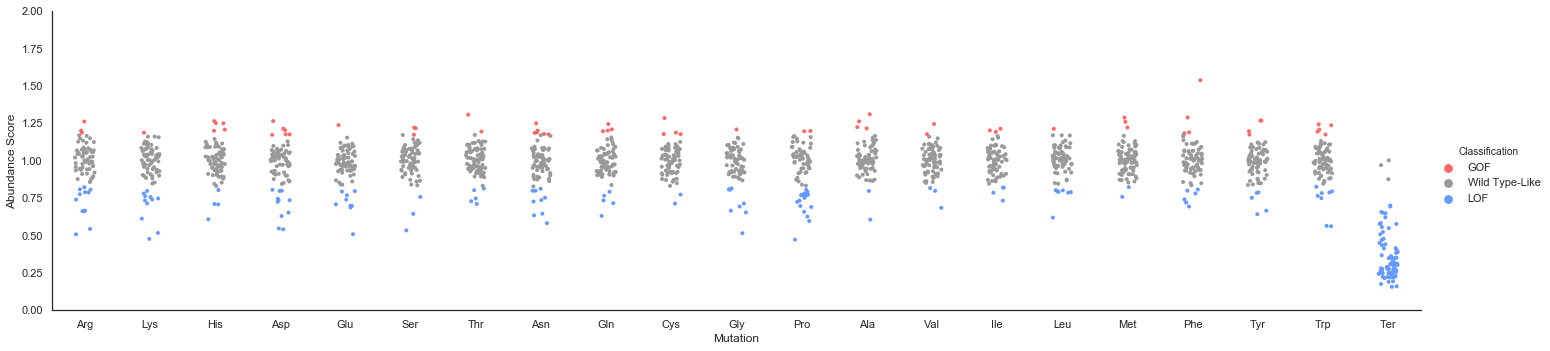

In [128]:
sns.set(font_scale=1.0)
sns.set(style='white')

myplot = sns.catplot(
    data = catplot_data,
    x = 'Mutation',
    y = 'flag/myc, WT normalized, protein variant',
    height = 5,
    aspect = 4,
    jitter = 0.15,
    s = 4,
    hue = 'Classification',
    hue_order = ['GOF', 'Wild Type-Like', 'LOF'],
    palette = sns.color_palette(['#FF6666', '#999999', '#6699FF', '#000000']),
    order=['Arg', 'Lys', 'His', 'Asp', 'Glu', 'Ser', 'Thr', 'Asn', 'Gln', 'Cys', 'Gly', 'Pro', 'Ala', 'Val', 'Ile', 'Leu', 'Met', 'Phe', 'Tyr', 'Trp', 'Ter']
    
)
plt.ylim(0, 2)
#plt.xticks(rotation=45)
plt.ylabel('Abundance Score')
plt.xlabel('Mutation')
myplot.savefig('Effect of Substitution on Abundance.svg')

